In [24]:
import numpy as np
from acrobotics.geometry import Box, Scene
from acrobotics.robot import Robot, Tool
from acrobotics.link import DHLink, Link, JointType
from acrobotics.util import translation, pose_z, get_default_axes3d
from acrobotics.util import plot_reference_frame

# Robot models

Let's build robots! Or at least highly simplified wireframe plots of robots. The obvious class to use is `Robot`. It's a base class used to create specific robots. A robot consist of links an optionally a tool. These two objects are also classes, `Link` and `Tool`.

## A robot has links
So let's start with the most basic part, a link. We create a nice `Scene` of shapes to represent the link.

In [25]:
link_geometry = Scene([Box(1, 0.1, 0.1)],
                           [translation(0.5, 0, 0)])

Notice that by default a box is centered around it's reference frame. We move it by one half of it's length in the x direction by passing the transform `translation(0, 0.5, 0, 0)`.
And we specify the Denavit-Hartenberg parameters using a named tuple `DHLink` with field (a, alpha, d, beta). In this case the first link of a 3R robot without offset or other strange stuff.

In [26]:
link_dh_parameters = DHLink(1, 0, 0, 0)

Now we can create a Link of the revolute type (`'r'`). For a prismatic link one uses `'p'`.

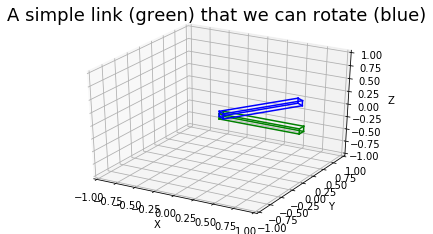

In [27]:
first_link = Link(link_dh_parameters, JointType.revolute , link_geometry)

# general plotting administration
fig, ax = get_default_axes3d()
ax.set_title('A simple link (green) that we can rotate (blue)',
             fontsize='18')


# actually plotting the link
first_link.plot(ax, np.eye(4), c='green')

# we can even rotate the link
first_link.plot(ax, pose_z(1.0, 0, 0, 0), c='blue')

If you are confused about my seemingly arbitrary api of `Scene` and `Box`, have a look at the page [Geometry, shapes and collision checking](geometry.ipynb).

## A robot has tools (sometimes)

A tool is a `Scene` of with one extra feature, can you guess what?    
Correct! A tool tip. This tell's the robot which frame to use when calculating forward and inverse kinematics. For example, a welding robot has a tip of the welding torch that has to be at the right place in the right time. This is where the tip frame is located.
I have modelled a nice torch using boxes to show you this:

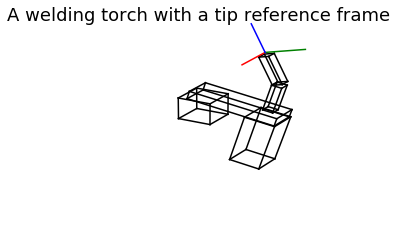

In [28]:
from acrobotics.tool_examples import torch

fig, ax = get_default_axes3d(xlim=[-0.2, 0.2], ylim=[-0.2, 0.2], zlim=[-0.2, 0.2])
ax.set_title('A welding torch with a tip reference frame', fontsize='18')
ax.set_axis_off()

torch.plot(ax, c='black')
plot_reference_frame(ax, torch.tf_tool_tip, arrow_length=0.1)

## A robot has robots

Uh, wait?! Ok let's bring it all togheter and create the 3R robot a mentioned earlier. But let's call it PlanarArm, as Siciliano does in his [book](https://www.springer.com/us/book/9781846286414).

In [29]:
class PlanarArm(Robot):
    """ Robot defined on page 69 in book Siciliano """

    def __init__(self, a1=1, a2=1, a3=1):
        geometry = [Scene([Box(a1, 0.1, 0.1)], [translation(-a1/2, 0, 0)]),
                    Scene([Box(a2, 0.1, 0.1)], [translation(-a2/2, 0, 0)]),
                    Scene([Box(a3, 0.1, 0.1)], [translation(-a3/2, 0, 0)])]
        super().__init__(
                [Link(DHLink(a1, 0, 0, 0), JointType.revolute, geometry[0]),
                 Link(DHLink(a2, 0, 0, 0), JointType.revolute, geometry[1]),
                 Link(DHLink(a3, 0, 0, 0), JointType.revolute, geometry[2])]
                )

robot = PlanarArm(a3 = 0.2)

By default you can calculate foward kinematics using `robot.fk(joint_values)`, check for collision `is_in_collision(Scene)` and visualize the robot (discussed in the next section).

In [30]:
robot.fk([0, 0, 0])

array([[1. , 0. , 0. , 2.2],
       [0. , 1. , 0. , 0. ],
       [0. , 0. , 1. , 0. ],
       [0. , 0. , 0. , 1. ]])

In [32]:
joint_angles = [0.6, -1.1, 0.3]

good_box = Scene([Box(0.5, 0.5, 0.5)], [translation(1.5, 1.5, 0)])
bad_box = Scene([Box(0.5, 0.5, 0.5)], [translation(1.5, 0, 0)])

res1 = robot.is_in_collision(joint_angles, good_box)
res2 = robot.is_in_collision(joint_angles, bad_box)

print(f"Collides with good box? {res1}")
print(f"Collides with bad box? {res2}")

Collides with good box? False
Collides with bad box? True


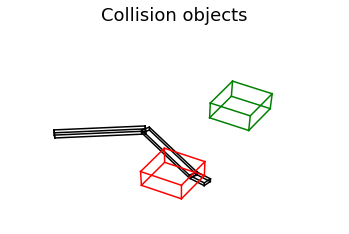

In [33]:
fig, ax = get_default_axes3d(xlim=[0, 2], ylim=[0, 2], zlim=[-1, 1])
ax.set_title('Collision objects', fontsize='18')
ax.view_init(elev=60)
ax.set_axis_off()

robot.plot(ax, joint_angles, c='black')
good_box.plot(ax, c='green')
bad_box.plot(ax, c='red')

But inverse kinematics don't come for free. Analytic inverse kinematics are implemented for specific robots in `acrobotics.inverse_kinematics.<robot_name>.py`.

For example the anthropomorphic arm is a robot with 3 revolute joints. The frist one parellel with the z-axis and the other two perpendicular to the first. (Similar to a 2R arm, but in 3D like a crane.)
For a reachable position in Cartesian space, there are multiple robot configurations that get the end-effector in this position. (The orientation is ignored bij the inverse kinematics algorithm for this specific robot.)

Can we reach this position? True


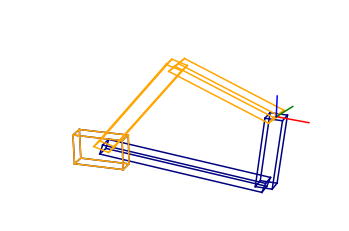

In [37]:
from acrobotics.robot_examples import AnthropomorphicArm

robot_2 = AnthropomorphicArm(a3=0.7)
pose = translation(1.0, 0.2, 0.5)

ik_sol = robot_2.ik(pose)
print(f"Can we reach this position? {ik_sol.success}")

fig, ax = get_default_axes3d(xlim=[0, 1], ylim=[-0.5, 0.5], zlim=[0, 1])
ax.set_axis_off()

colors = ['navy', 'orange']
for color, qi in zip(colors, ik_sol.solutions):
    robot_2.plot(ax, qi, c=color)
plot_reference_frame(ax, pose)

## Show me them robots

Now we can visualize the robot using the `Robot.plot(axes_handle, joint_values, ...)` function. Using the `get_default_axes3d` from `acrobotics.util` reduces setup code to create a 3D plot (by 8 lines).

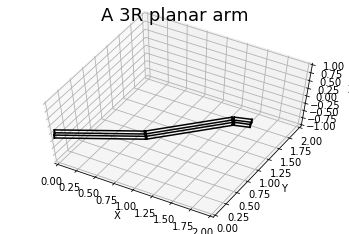

In [38]:
# specify some joint angles for the plot
q_plot = [0.5, 0.3, -0.5]

fig, ax = get_default_axes3d(xlim=[0, 2], ylim=[0, 2], zlim=[-1, 1])
ax.set_title('A 3R planar arm', fontsize='18')
ax.view_init(elev=60)

robot.plot(ax, q_plot, c='black')

Notice that the link frames lie at the end of a link. This is a confusing consequence from using Denavit-Hartenberg parameters. If I get to annoyed by it I will change this.

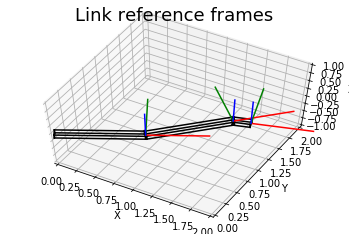

In [39]:
fig, ax = get_default_axes3d(xlim=[0, 2], ylim=[0, 2], zlim=[-1, 1])
ax.set_title('Link reference frames', fontsize='18')
ax.view_init(elev=60)

robot.plot(ax, q_plot, c='black')

tf_links = robot.fk_all_links(q_plot)
for tfl in tf_links: plot_reference_frame(ax, tfl, 0.7)

Also you can just plot the kinematics structure of the robot to get an idea whether you did it right without all the wireframes getting in your way.

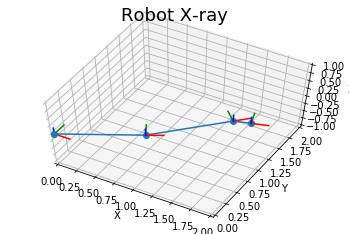

In [40]:
fig, ax = get_default_axes3d(xlim=[0, 2], ylim=[0, 2], zlim=[-1, 1])
ax.set_title('Robot X-ray', fontsize='18')
ax.view_init(elev=60)

robot.plot_kinematics(ax, q_plot)

## Give it some tools

We can give the robot a pen to write on a blackboard. (A long stick as end-effector and a flat plane as collision environment.)

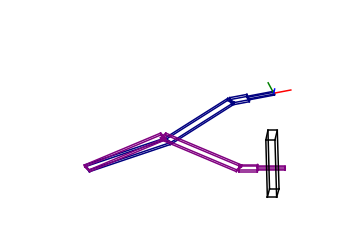

In [45]:
# create with a list of shapes, a list of tfs for the shapes
# and a tf to specify the tool tip relative to the last link
pen = Tool([Box(0.3, 0.05, 0.05)],
           [translation(0.15, 0, 0)],
           translation(0.3, 0, 0))

robot.tool = pen

blackboard = Scene([Box(0.1, 1.0, 0.5)],
                   [translation(2, 0, 0.25)])

fig, ax = get_default_axes3d(xlim=[0, 2],
                             ylim=[0, 2],
                             zlim=[-1, 1])
ax.view_init(elev=70, azim = -90)
ax.set_axis_off()

q1 = [0.5, 0.3, -0.5]
q2 = [0.6, -1.2, 0.6]

robot.plot(ax, q1, c='navy')
robot.plot(ax, q2, c='purple')

plot_reference_frame(ax, robot.fk(q1))
blackboard.plot(ax, c='black')

The tool is also added during collision checking with the environment.

In [46]:
print(robot.is_in_collision(q1, blackboard))
print(robot.is_in_collision(q2, blackboard))

False
True
